In [92]:
# Imports
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import shutil
import random

# 0. EDA and File Management
# b) Read in 10 random images, plot and extract their labels and print them in the title.

In [93]:
paths = {
    # Paths to the original training and testing data
    "original_train_data": "original_data/train/train",
    "original_test_data": "original_data/test/test",
    # Path to experiment_small_data and experiment_tiny_data
    "experiment_small_dir": "experiment_small_data", 
    "experiment_tiny_dir": "experiment_tiny_data" 
}

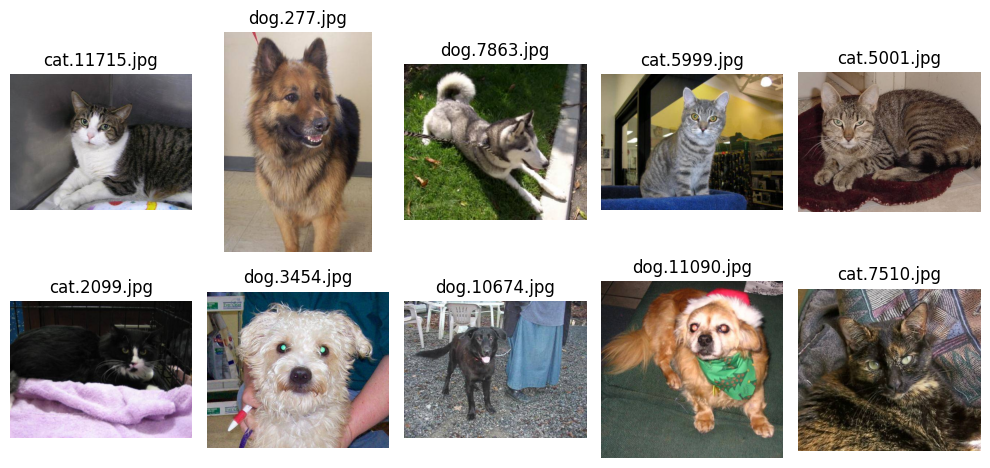

In [94]:
# Function to load 10 random images
def load_10_random_images(directory, num_images=10):
    image_files = os.listdir(directory)
    random_indices = np.random.choice(len(image_files), num_images, replace=False)
    random_images = [(Image.open(os.path.join(directory, image_files[i])), image_files[i]) for i in random_indices]
    return random_images

# Directory for the training data that includes all images of cats or dogs
image_dir = paths["original_train_data"]

images_with_labels = load_10_random_images(image_dir)

# Plot pictures with their label as a title for each picture
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(images_with_labels):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# C) Creating the folder structure

In [95]:
# Function for creating the main folder structure
# The original_data folder is manually renamed with all the data downloaded and extracted from: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
def create_folder_structure():
    folders = ['experiment_small_data', 'experiment_tiny_data']
    subfolders = ['test', 'train', 'val']

    for f in folders:
        os.makedirs(f, exist_ok=True)
        for sf in subfolders:
            os.makedirs(os.path.join(f, sf), exist_ok=True)

# Call the function
create_folder_structure()

# D) Clear subfolder directories within experiment folders and train|val|test splits

In [104]:
# experiment_small_data
# train - total 1600 (800 dogs, 800 cats)
# val - total 400 (200 dogs, 200 cats)
# test - total 500 (250 dogs, 250 cats)

# experiment_tiny_data (BONUS)
# train - total 160 (80 dogs, 80 cats)
# val - total 40 (20 dogs, 20 cats)
# test - total 50 (25 dogs, 25 cats)

# Collect all images from train and test directories
train_images = os.listdir(paths["original_train_data"])
test_images = os.listdir(paths["original_test_data"]) 

# Separate dogs and cats in the training data based on filenames
dog_images = [img for img in train_images if 'dog' in img] 
cat_images = [img for img in train_images if 'cat' in img]

# Function to clear directories to avoid exceeding the desired amount of images when calling the function to create the splits
def clear_directory(directory):
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)


# Function for copying files to subfolders within experiment folders.
def copy_files(file_list, destination, source_dir):
    for file in file_list:
        src = os.path.join(source_dir, file)
        dest = os.path.join(destination, file)
        shutil.copy(src, dest)


def create_splits(dog_images, cat_images, test_images, train_size, val_size, test_size, output_path):
    random.shuffle(dog_images)
    random.shuffle(cat_images)
    random.shuffle(test_images)

    train_dir = os.path.join(output_path, 'train')
    val_dir = os.path.join(output_path, 'val')
    test_dir = os.path.join(output_path, 'test')
     
    # Clear the destination directories
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    # Calculation for train,val,test to get the right amount
    train_dogs = dog_images[:train_size // 2] 
    train_cats = cat_images[:train_size // 2] 
    val_dogs = dog_images[train_size // 2:train_size // 2 + val_size // 2] 
    val_cats = cat_images[train_size // 2:train_size // 2 + val_size // 2] 
    test_subset = test_images[:test_size] 

    copy_files(train_dogs, train_dir, paths["original_train_data"]) # Dogs training images
    copy_files(train_cats, train_dir, paths["original_train_data"]) # Cats training images
    copy_files(val_dogs, val_dir, paths["original_train_data"]) # Dogs val images
    copy_files(val_cats, val_dir, paths["original_train_data"]) # Cats val images
    copy_files(test_subset, test_dir, paths["original_test_data"]) # Testing images 

create_splits(dog_images, cat_images, test_images, 1600, 400, 500, paths["experiment_small_dir"]) # train, val, test (1600, 400, 500)
create_splits(dog_images, cat_images, test_images, 160, 40, 50, paths["experiment_tiny_dir"]) # train, val, test (160, 40, 50)